# Create simulated variable stars - example

Below is an example specific to VV124 (data provided in test_data folder), which could be adapted fairly easily for any photometric catalogs from DAOPHOT. This program *does not* include period fitting, but creates light curve files that are compatible with the template fitting IDL program FITLC (Sarajedini et al. 2009). Modifications to variable_simulations.py would be necessary for compatibility with other period fitting software.

In [1]:
from Variable_Star_Analysis import variable_simulations as vs
import numpy as np
import matplotlib.pyplot as plt 

%load_ext autoreload
%autoreload 2

## Setup

You will likely need to write your own function to describe the properties (scatter, photometric uncertainty as a function of magnitude) of your dataset in order to run the best simulations. The functions below are specific to the format of the photometric catalogs in the test data.   


*Requirements* <br>
You must create three arrays, which are used to interpolate the proper scatter (between observations of the same star) and photometric uncertainty (of individual measurements) for a given magnitude. Below is a description of the three arrays.


- error_key - Lists the filter/exposure time pairs of your dataset. Example format: 
    `np.zeros(nrows, dtype=np.dtype([('filter', 'U5'), ('exptime', float)]))`
    where nrows is the number of filter/exptime pairs in your dataset
- error_array - Contains the typcial photometric uncertainty, and standard deviation of photometric uncertainty for several magnitude bins. Dimensions are (num filter/exptime pairs, num of magnitude bins, 3). Example format: 
`np.zeros((nrows,nbins,3))` where nrows is the number of filter/exptime pairs, and nbins is the number of magnitude bins appropriate for you data. 
- scatter_array - Contains the typical scatter between observations of the same star, for several magnitude bins, as well as the standard deviation of observed scatters within that bin. Example format: 
`np.zeros((n_filters,nbins,3))` where n_filters is the number of filters in your dataset and nbins is the number of magnitude bins (ideally same as in error_array)

In [2]:
from scipy.stats import binned_statistic

def mad(x):
        med_x = np.nanmedian(x)
        return np.nanmedian(np.abs(x - med_x))

def get_properties(n_epochs):

    n_filters = 2

    multiepoch_data = np.loadtxt('../test_data/vv124/vv124_allcal_12_1line.raw.tran')


    b_mags = multiepoch_data[:,3:3+n_epochs*2:2]
    b_emags = multiepoch_data[:,4:4+n_epochs*2:2]

    i_mags = multiepoch_data[:,3+n_epochs*2:-2:2]
    i_emags = multiepoch_data[:,4+n_epochs*2:-2:2]

    b_mags[b_mags > 50] = np.nan
    b_emags[b_emags > 5] = np.nan
    i_mags[i_mags > 50] = np.nan
    i_emags[i_emags > 5] = np.nan

    b_mags[b_mags == 0.0] = np.nan
    b_emags[b_emags == 0.0] = np.nan
    i_mags[i_mags == 0.0] = np.nan
    i_emags[i_emags == 0.0] = np.nan

    sharp = multiepoch_data[:,-1]

    sharp_repeat = np.zeros((len(sharp), len(b_mags[0])))
    for i in range(len(b_mags[0])):
        sharp_repeat[:,i] = sharp
    sharp_flat = sharp_repeat.flatten()

    low_sharp = np.abs(sharp) < 0.1
    low_sharp_flat = np.abs(sharp_flat) < 0.1

    dt = np.dtype([('filter', 'U5'), ('exptime', float)])
    nrows = 2
    nbins = 15

    error_key = np.zeros(nrows, dtype=dt)

    error_key['filter'][0] = 'F475W'
    error_key['filter'][1] = 'F814W'
    error_key['exptime'][0] = 1400
    error_key['exptime'][1] = 1200

    error_array = np.zeros((nrows,nbins,3))
    scatter_array = np.zeros((n_filters,nbins,3))

    b_mags_flat = b_mags.flatten()
    b_emags_flat = b_emags.flatten()
    i_mags_flat = i_mags.flatten()
    i_emags_flat = i_emags.flatten()

    notnan = ~np.isnan(b_mags_flat) & ~np.isnan(b_emags_flat)
    select = notnan & low_sharp_flat

    phot_unc, edges, _ = binned_statistic(b_mags_flat[select], b_emags_flat[select],
                    'median', bins=nbins)
    sig_phot_unc, edges2, _ = binned_statistic(b_mags_flat[select], b_emags_flat[select],
                    statistic=mad, bins=nbins)

    centers1 = (edges[:-1] + edges[1:])/2.0

    error_array[0,:,0] = centers1
    error_array[0,:,1] = phot_unc
    error_array[0,:,2] = sig_phot_unc


    fig, ax = plt.subplots(1,1)

    ax.scatter(b_mags_flat[select], b_emags_flat[select], s=0.1, color='k', alpha=0.1)
    ax.errorbar(centers1, phot_unc, yerr=sig_phot_unc, fmt='o', color='orange')
    #ax.set_ylim(0,0.4)
    ax.set_xlabel('{} mag'.format('F475W'))
    ax.set_ylabel('$\sigma_i$ {}'.format('F475W'))
    ax.text(0.1, 0.9, 'Exp = {} s'.format(1400), transform=ax.transAxes)

    plt.show()

    # repeat for i band
    notnan = ~np.isnan(i_mags_flat) & ~np.isnan(i_emags_flat)
    select = notnan & low_sharp_flat

    phot_unc, edges, _ = binned_statistic(i_mags_flat[select], i_emags_flat[select],
                    'median', bins=nbins)
    sig_phot_unc, edges2, _ = binned_statistic(i_mags_flat[select], i_emags_flat[select],
                    statistic=mad, bins=nbins)

    centers1 = (edges[:-1] + edges[1:])/2.0

    error_array[1,:,0] = centers1
    error_array[1,:,1] = phot_unc
    error_array[1,:,2] = sig_phot_unc


    fig, ax = plt.subplots(1,1)

    ax.scatter(i_mags_flat[select], i_emags_flat[select], s=0.1, color='k', alpha=0.1)
    ax.errorbar(centers1, phot_unc, yerr=sig_phot_unc, fmt='o', color='orange')
    #ax.set_ylim(0,0.4)
    ax.set_xlabel('{} mag'.format('F814W'))
    ax.set_ylabel('$\sigma_i$ {}'.format('F814W'))
    ax.text(0.1, 0.9, 'Exp = {} s'.format(1200), transform=ax.transAxes)

    plt.show()

    b_mean_mags = np.nanmean(b_mags, axis=1)
    b_stds = np.nanstd(b_mags, axis=1)
    i_mean_mags = np.nanmean(i_mags, axis=1)
    i_stds = np.nanstd(i_mags, axis=1)

    notnan = ~np.isnan(b_mean_mags) & ~np.isnan(b_stds)
    select = notnan & low_sharp
    scatter, edges, _ = binned_statistic(b_mean_mags[select], b_stds[select],
        'median', bins=nbins)
    sig_scatter, edges2, _ = binned_statistic(b_mean_mags[select], b_stds[select],
        statistic=mad, bins=nbins)

    centers2 = (edges[:-1] + edges[1:])/2.0

    scatter_array[0,:,0] = centers2
    scatter_array[0,:,1] = scatter
    scatter_array[0,:,2] = sig_scatter

    fig, ax = plt.subplots(1,1)

    ax.scatter(b_mean_mags[select], b_stds[select], s=0.1, color='k', alpha=0.1)
    ax.errorbar(centers2, scatter, yerr=sig_scatter, fmt='o', color='orange')
    #ax.set_ylim(0,0.4)
    ax.set_xlabel('{} mag'.format('F475W'))
    ax.set_ylabel('$\sigma$ {}'.format('F475W'))

    plt.show()

    notnan = ~np.isnan(i_mean_mags) & ~np.isnan(i_stds)
    select = notnan & low_sharp
    scatter, edges, _ = binned_statistic(i_mean_mags[select], i_stds[select],
        'median', bins=nbins)
    sig_scatter, edges2, _ = binned_statistic(i_mean_mags[select], i_stds[select],
        statistic=mad, bins=nbins)

    centers2 = (edges[:-1] + edges[1:])/2.0

    scatter_array[1,:,0] = centers2
    scatter_array[1,:,1] = scatter
    scatter_array[1,:,2] = sig_scatter

    fig, ax = plt.subplots(1,1)

    ax.scatter(i_mean_mags[select], i_stds[select], s=0.1, color='k', alpha=0.1)
    ax.errorbar(centers2, scatter, yerr=sig_scatter, fmt='o', color='orange')
    #ax.set_ylim(0,0.4)
    ax.set_xlabel('{} mag'.format('F814W'))
    ax.set_ylabel('$\sigma$ {}'.format('F814W'))

    plt.show()

    return error_key, error_array, scatter_array


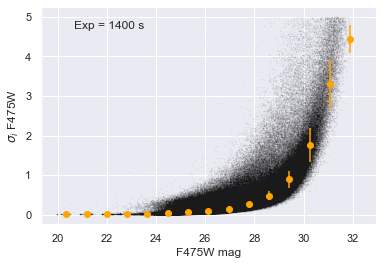

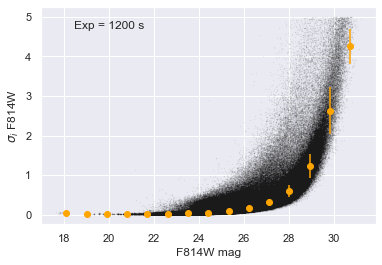

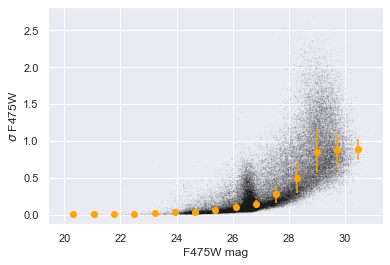

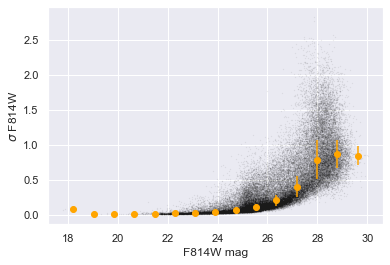

In [3]:
error_key, error_array, scatter_array = get_properties(14)

The dataset property arrays are printed below for clarity on their format. 

In [4]:
print ('Error_key:')
print(error_key)
print('\n\nError Array:')
print(error_array)
print('\n\nScatter Array:')
print(scatter_array)

Error_key:
[('F475W', 1400.) ('F814W', 1200.)]


Error Array:
[[[2.03523e+01 1.29000e-02 2.10000e-03]
  [2.11769e+01 1.64000e-02 2.75000e-03]
  [2.20015e+01 1.80000e-02 3.40000e-03]
  [2.28261e+01 2.04000e-02 4.80000e-03]
  [2.36507e+01 2.86000e-02 8.40000e-03]
  [2.44753e+01 3.81000e-02 1.06000e-02]
  [2.52999e+01 5.75000e-02 1.65000e-02]
  [2.61245e+01 9.22000e-02 2.39000e-02]
  [2.69491e+01 1.34000e-01 3.29000e-02]
  [2.77737e+01 2.65900e-01 6.68000e-02]
  [2.85983e+01 4.78900e-01 1.18800e-01]
  [2.94229e+01 8.94300e-01 2.20700e-01]
  [3.02475e+01 1.76505e+00 4.25750e-01]
  [3.10721e+01 3.29855e+00 6.34850e-01]
  [3.18967e+01 4.43720e+00 3.48400e-01]]

 [[1.81056e+01 5.29000e-02 1.25000e-02]
  [1.90068e+01 2.37500e-02 4.35000e-03]
  [1.99080e+01 2.10000e-02 4.40000e-03]
  [2.08092e+01 2.05000e-02 3.70000e-03]
  [2.17104e+01 2.21000e-02 4.40000e-03]
  [2.26116e+01 2.57000e-02 5.60000e-03]
  [2.35128e+01 3.46000e-02 8.00000e-03]
  [2.44140e+01 5.31000e-02 1.37000e-02]
  [2.53152e+01 8

## Generate Simulated star parameters


This step is independent of your dataset, and simply generates the basic parameters
of the simulated stars based on the distributions of variables in the LMC. It is 
currently possible to create simulated first overtone/fundamental Classical Cepheids (CEP), first overtone/fundamental RR Lyrae stars (RRL), 
first overtone/fundamental Anomalous Cepheids (AC), and BL Her/W Virginis Type II Cepheids (T2C)


The arguments you must give the function `simulate_params` are: 
1. array of types of variables you want to generate. Pick from ['CEP', 'RRL', 'AC', 'T2C'].
2. the number of each type of variable/subtype you want to generate. 
3. the local path to the OGLEIV LMC data 
4. (optional) a seed for the random generators. In practice, you should use seed=0 to get random results, but for repeatability you may explicitly set a seed (as we have done in this notebook). 

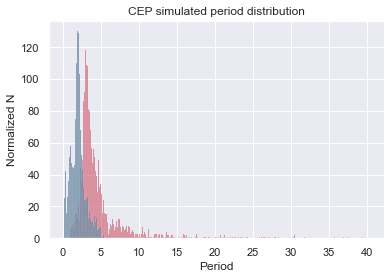

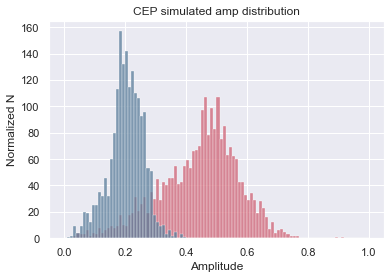

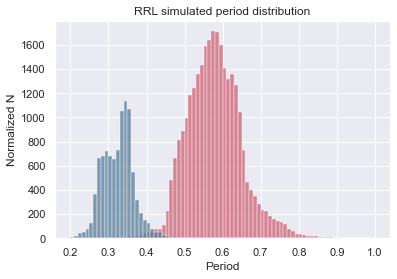

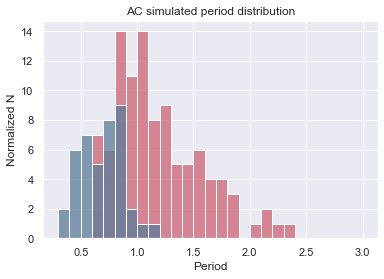

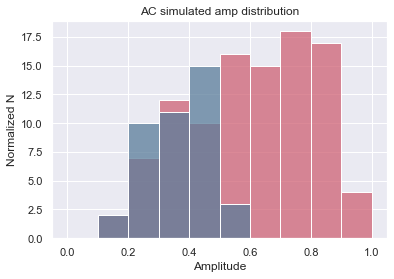

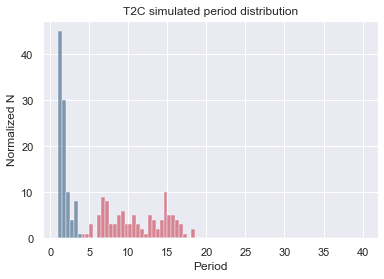

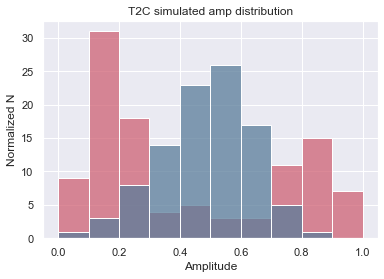

Total number of simulated stars: 1000
sim_data array:
[(  1, 'CEP', 'FO', 0.85967647, 16.16205484, 0.21421654)
 ( 51, 'CEP', 'FO', 1.73153139, 15.47694242, 0.2433117 )
 (101, 'CEP', 'FO', 0.8710761 , 16.49331731, 0.18253379)
 (151, 'CEP', 'FU', 2.80246943, 15.1142951 , 0.52405455)
 (201, 'CEP', 'FU', 3.06965474, 15.51265345, 0.49256998)
 (251, 'RRL', 'FO', 0.28596765, 18.73400344, 0.27148225)
 (301, 'RRL', 'FO', 0.31315314, 18.58699145, 0.3235881 )
 (351, 'RRL', 'FO', 0.27710761, 18.72195205, 0.28051396)
 (401, 'RRL', 'FU', 0.51024694, 18.4538642 , 0.51536091)
 (451, 'RRL', 'FU', 0.54696547, 18.5657938 , 0.38494401)
 (501, 'AC', 'FO', 0.55967647, 17.22495002, 0.34216543)
 (551, 'AC', 'FO', 0.63153139, 17.37348127, 0.63311697)
 (601, 'AC', 'FO', 0.3710761 , 18.16447628, 0.32533789)
 (651, 'AC', 'FU', 0.90246943, 17.1389613 , 0.74054548)
 (701, 'AC', 'FU', 0.86965474, 17.97401042, 0.72569976)
 (751, 'T2C', 'FO', 1.79838236, 16.83842024, 0.44216543)
 (801, 'T2C', 'FO', 1.65765695, 17.7147

In [5]:
# path to where you have downloaded ogle data 
ogle4_dir = '/Users/jill/Research/Surveys/OGLE/OGLEIV/LMC/'

# generate parameters (period, amp, I mean mag) of simulated stars
sim_data = vs.simulate_params(['CEP', 'RRL', 'AC', 'T2C'], 125, ogle4_dir, seed=5)

print('Total number of simulated stars:', len(sim_data['id']))
print('sim_data array:')
print(sim_data[0:-1:50])

## Generate simulated light curves

The following cell generates the simulated light curve files, which are specific to your dataset.

You must provide the function `make_simulated_lcv` the following arguments: 
1. data array created above in `simulate_params`
2. array with MJDs of your observations. MJDs can be in any order, but they should correspond to the appropriate filter (next argument). 
3. array of filter name of each observation. 
4. arrray of exposure times of each observation. 
5. approximate distance modulus of the target/variables you are analyzing
6. scatter_array from setup 
7. error_key from setup 
8. error_array from setup 
9. output directory where you want your simulated light curves to be written 


Optional keyword arguments: 
1. append - Default False. Set to True if you want to create more simulated stars without overwriting previously created ones 
2. period_search_range - The range in days over which you want to fit templates. Used in FITLC header. Default 0.1 - 3.0 days
3. rrl_cutoff - Approximate magnitude cutoff to differentiate RRL and Cepheids. Stars with mean mag below cutoff will have a shortened period_search_range of 0.1 - 1.0 days. Stars above this cutoff will use the period_search_range you set. 
4. template_file - path/name of the file that has FITLC light curve templates 
5. seed - If seed != 0 then a seed will be provided to the random number generators for repeatability. By default set to 0, so output will not be repeatable. 

In [6]:
output_dir = '../test_data/vv124/simulations/lcvs/'
distance = 25.8 # approximate distance modulus 

filters1 = np.repeat('B', 14)
filters2 = np.repeat('I', 14)
filters = np.append(filters1, filters2)

# HST filters are not currently supported, so change names to closest ground based filters
error_key['filter'][error_key['filter'] == 'F475W'] = 'B'
error_key['filter'][error_key['filter'] == 'F814W'] = 'I'

mjds = np.array([58490.640099000, 58490.838859000, 58491.771357000, 58491.847075000, 58492.427560000,
                58492.504885000, 58492.824905000, 58492.906455000, 58495.803519000, 58495.885266000,
                58496.332749000, 58496.414009000, 58496.531369000, 58496.612676000, 58490.657217000,
                58490.855977000, 58491.782763000, 58491.823596000, 58492.444678000, 58492.487119000, 
                58492.842023000, 58492.888689000, 58495.820637000, 58495.867500000, 58496.349867000,
                58496.396243000, 58496.548487000, 58496.594910000])

exptimes1 = np.repeat(1400, 14)
exptimes2 = np.repeat(1200, 14)
exptimes = np.append(exptimes1, exptimes2)

vs.make_simulated_lcv(sim_data, mjds, filters, 
    exptimes, distance, scatter_array, error_key, error_array, 
    output_dir, append=False, period_search_range=[0.3, 6.0], rrl_cutoff=25.3, 
    template_file='../var_templates.txt', seed=5)

## Visualizations

In the cells below we show a few visualizations to demonstrate the output of the simulations. First a few example light curves, then the period-luminosity relation and period-color relation of the simulated stars. 


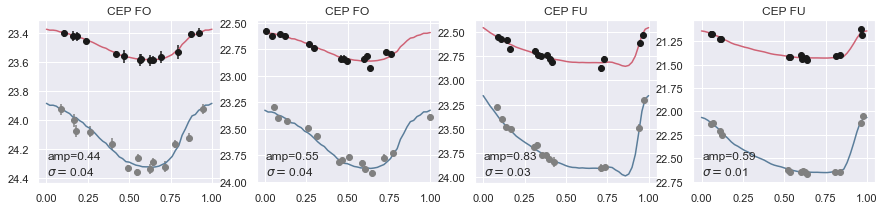

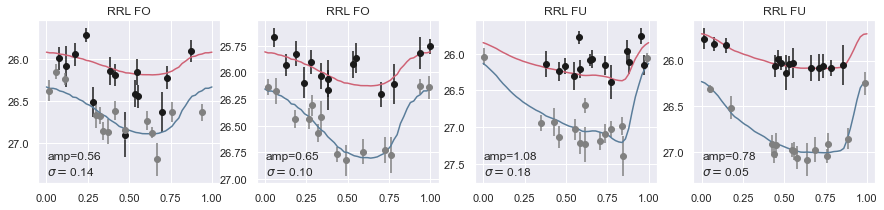

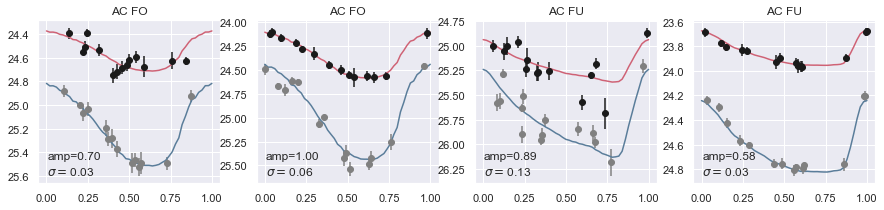

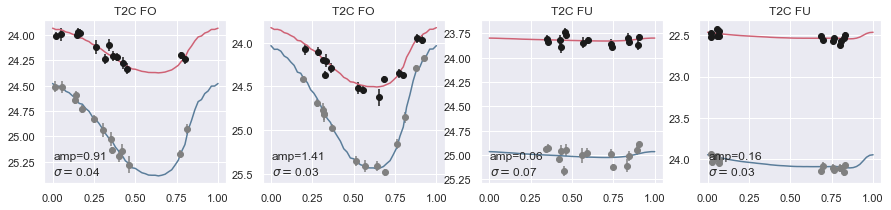

In [7]:
# Plot a couple lcvs of each type to be sure they look ok 

# read parameter file 
dt = np.dtype([('id', int), ('type', 'U3'), ('mode', 'U2'), ('template', int), ('period', float), 
              ('t0', float), ('mag1', float), ('amp1', float), ('sig1', float), ('mag2', float), 
              ('amp2', float), ('sig2', float)])
data = np.loadtxt('../test_data/vv124/simulations/lcvs/true_params.txt', dtype=dt)

# Get template light curves
template_file = '../var_templates.txt'
dt = np.dtype([('phase', float), ('ab1', float), ('ab2', float),
        ('ab3', float), ('ab4', float), ('ab5', float), ('ab6', float),
        ('c', float), ('ab7', float), ('ab8', float)])
templates = np.loadtxt(template_file, dtype=dt)
templates_new = np.c_[templates['ab1'], templates['ab2'], templates['ab3'],
        templates['ab4'], templates['ab5'], templates['ab6'], templates['c'],
        templates['ab7'], templates['ab8']]
templates_mean = np.mean(templates_new, axis=0)


for i in range(4): 
    
    n = 125
    
    star_indices = [n*2*i, n*2*i+1, n+2*n*i, n+2*n*i+1]
    
    fig, ax = plt.subplots(1,4, figsize=(15,3))
    
    for j in range(len(star_indices)):
        xx = star_indices[j]
        t = data['template'][xx]
        mag_temp1 = (templates_new[:,t]-templates_mean[t])*data['amp1'][xx] + data['mag1'][xx]
        ax[j].plot(templates['phase'], mag_temp1, color='xkcd:steel blue')
        mag_temp2 = (templates_new[:,t]-templates_mean[t])*data['amp2'][xx] + data['mag2'][xx]
        ax[j].plot(templates['phase'], mag_temp2, color='xkcd:rose')
        ax[j].set_title('{} {}'.format(data['type'][xx], data['mode'][xx]))
        #ax[j].set_title(var_types[j])
        ax[j].invert_yaxis()
        
        # read in lcv data 
        dt = np.dtype([('filter', int), ('mjd', float), ('mag', float), ('err', float)])
        lcv = np.loadtxt('../test_data/vv124/simulations/lcvs2/sim_{}.fitlc'.format(xx+1), dtype=dt, skiprows=3)
        ph = np.mod((lcv['mjd']-data['t0'][xx])/data['period'][xx], 1)
        f1 = lcv['filter'] == 1
        ax[j].errorbar(ph[f1], lcv['mag'][f1], yerr=lcv['err'][f1], fmt='o', color='k')
        f2 = lcv['filter'] == 0
        ax[j].errorbar(ph[f2], lcv['mag'][f2], yerr=lcv['err'][f2], fmt='o', color='gray')
        
        ax[j].text(0.05, 0.15, 'amp={:.2f}'.format(data['amp1'][xx]), transform=ax[j].transAxes)
        ax[j].text(0.05, 0.05, '$\sigma=${:.2f}'.format(data['sig1'][xx]), transform=ax[j].transAxes)
        
    plt.show()

Text(0, 0.5, 'B-I')

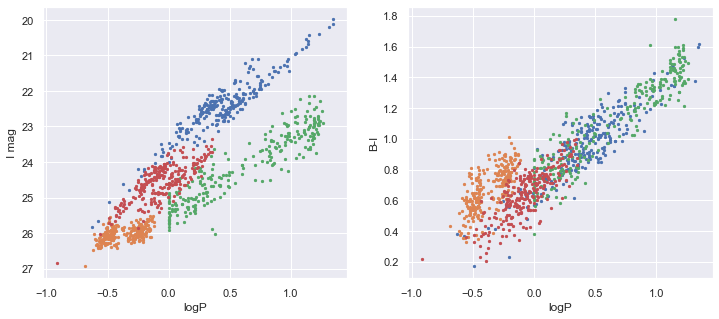

In [16]:
# Plot PL relation of simulated stars 
fig, ax = plt.subplots(1,2, figsize=(12,5))

cep = data['type'] == 'CEP'
rrl = data['type'] == 'RRL'
t2c = data['type'] == 'T2C'
ac = data['type'] == 'AC'

ax[0].scatter(np.log10(data['period'][cep]), data['mag2'][cep], s=5)
ax[0].scatter(np.log10(data['period'][rrl]), data['mag2'][rrl], s=5)
ax[0].scatter(np.log10(data['period'][t2c]), data['mag2'][t2c], s=5)
ax[0].scatter(np.log10(data['period'][ac]), data['mag2'][ac], s=5)

ax[0].invert_yaxis()
ax[0].set_xlabel('logP')
ax[0].set_ylabel('I mag')

ax[1].scatter(np.log10(data['period'][cep]), data['mag1'][cep] - data['mag2'][cep], s=5)
ax[1].scatter(np.log10(data['period'][rrl]), data['mag1'][rrl] - data['mag2'][rrl], s=5)
ax[1].scatter(np.log10(data['period'][t2c]), data['mag1'][t2c] - data['mag2'][t2c], s=5)
ax[1].scatter(np.log10(data['period'][ac]), data['mag1'][ac] - data['mag2'][ac], s=5)

ax[1].set_xlabel('logP')
ax[1].set_ylabel('B-I')


## Wrap Up 

After generating these simulated stars, run them through the period fitting program FITLC (or an equivalent program if you have modified the output light curves appropriately). Create a file called `sim_results.txt` that contains both the simulated and measured parameters for each star. If you are using the same file formats/directory structure as test_data, you can use the function `compile_sims` in `variable_simulations.py` to create the file `sim_results.txt`. Otherwise, copy the format of the file in the test_data foler. The last four columns of this file should be:
- variability flag - 1 if the simulated star would pass the variability identification criteria you set for your data (e.g. a variability index) , 0 otherwise. 
- visual flag - by default -1. This column will get filled in as you go through classification
- variable type - by default XXX. This column will get filled in as you go through classification
- variable subtype/mode - by default XX. This column will get filled in as you go through classification


To classify the simulated stars, run command 
`python variable_classification.py 'simulations'`